<a href="https://colab.research.google.com/github/odeya-shnaps/waste-classifier/blob/main/waste_sorter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Waste-Sorter**

In [125]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from tensorflow import keras

In [2]:
# mount the data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# unzip dataset
!rm -rf data
!cp /content/drive/MyDrive/trash_data/dataset-original.zip .
!mkdir data
!unzip -q dataset-original.zip -d data

In [4]:
import pathlib

data_dir = pathlib.Path('/content/data/dataset-original/')
count = len(list(data_dir.glob('*/*.jpg')))
print(count)

2527


In [45]:
batch_size = 32
img_height = 224
img_width = 224
val_split = 0.3
seed_train_val = 123

In [46]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=val_split,
  subset="training",
  seed=seed_train_val,
  image_size=(img_height, img_width),
  label_mode="categorical",
  batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 1769 files for training.


In [48]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=val_split,
  subset="validation",
  seed=seed_train_val,
  image_size=(img_height, img_width),
  label_mode="categorical",
  batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 758 files for validation.


In [49]:
# splitting val for test set
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

In [27]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [28]:
for images, labels in train_ds:
  print(images.shape)
  print(labels[0])
  break

(32, 224, 224, 3)
tf.Tensor([0. 0. 0. 0. 1. 0.], shape=(6,), dtype=float32)


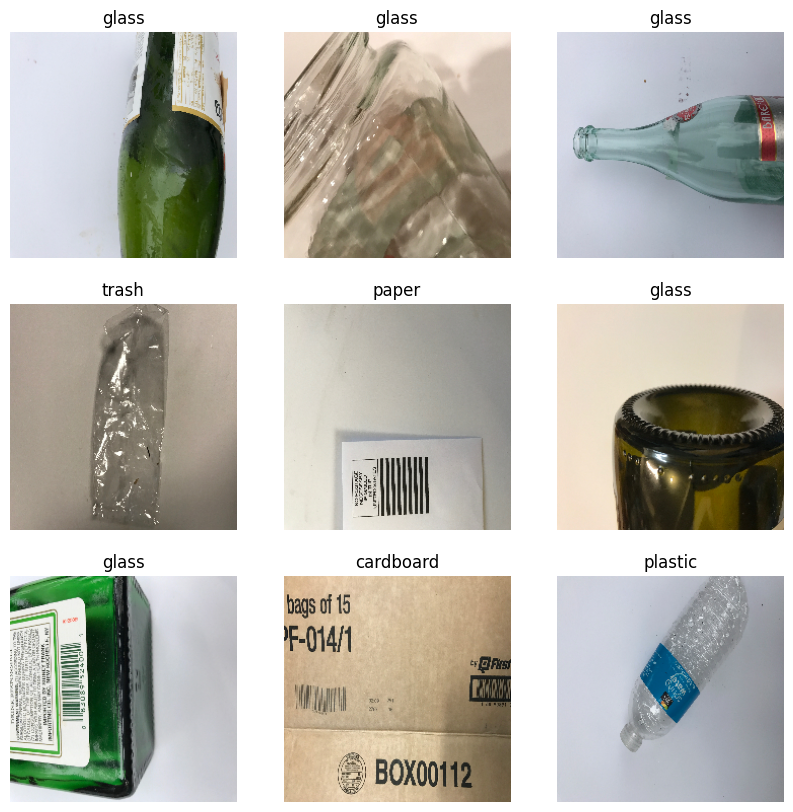

In [29]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [30]:
for images, labels in train_ds.take(1):
  img_shape = images[0].shape
  print(img_shape)
  break

(224, 224, 3)


**Normalizing the data**

In [124]:
from tensorflow.keras.applications.vgg16 import preprocess_input

normalization_layer = layers.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
#train_image, train_labels = next(iter(normalized_train_ds))

normalized_val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
#image_val_batch, labels_val_batch = next(iter(normalized_val_ds))

**VGG16 MODEL**

In [32]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_shape)
base_model.trainable = False ## Not trainable weights

##Preprocessing input
#train_ds = preprocess_input(train_ds)
#val_ds = preprocess_input(val_ds)

print(base_model.summary())

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [33]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(6, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 50)                  │       1,254,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,970,284 (60.92 MB)

 Trainable params: 1,255,596 (4.79 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [34]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

#model.fit(train_image, train_labels, validation_split=0.2, epochs=10, callbacks=[es], batch_size=32)
model.fit(normalized_train_ds, validation_data=normalized_val_ds, epochs=20, callbacks=[es])


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1149s 20s/step - accuracy: 0.4631 - loss: 2.7658 - val_accuracy: 0.7727 - val_loss: 1.5350
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1144s 20s/step - accuracy: 0.7433 - loss: 1.0153 - val_accuracy: 0.7273 - val_loss: 0.7803
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1130s 20s/step - accuracy: 0.8780 - loss: 0.4086 - val_accuracy: 0.9091 - val_loss: 0.1593
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1184s 20s/step - accuracy: 0.9448 - loss: 0.2043 - val_accuracy: 0.5909 - val_loss: 1.2608
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1169s 20s/step - accuracy: 0.9741 - loss: 0.1327 - val_accuracy: 0.8182 - val_loss: 0.4689
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1165s 20s/step - accuracy: 0.9839 - loss: 0.0615 - val_accuracy: 0.8182 - val_loss: 1.2133
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1116s 20s/step - accuracy: 0.9947 - loss: 0.0471 - val_accuracy: 0.7727 - val_loss: 0.5919
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1184s 20s/step - accuracy: 0.9971 - loss: 0.0220 - val_accu

**Prediction**

In [55]:
normalized_test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))
model.evaluate(normalized_test_ds)

16/16 ━━━━━━━━━━━━━━━━━━━━ 322s 19s/step - accuracy: 0.7373 - loss: 0.9846


[0.89680016040802, 0.736328125]

**prediction on a single image**

In [131]:
random_class = str(class_names[np.random.randint(0, 6)])
print(random_class)
rand_pic = str(np.random.randint(1, 100))
print(rand_pic)

cardboard
98


/content/data/dataset-original/cardboard/cardboard98.jpg


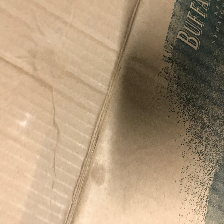

In [132]:
img_path = '/content/data/dataset-original/'+ random_class + '/' + random_class + rand_pic + '.jpg'
print(img_path)
#There is an interpolation method to match the source size with the target size
#image loaded in PIL (Python Imaging Library)
img = image.load_img(img_path,color_mode='rgb', target_size=(224, 224))
display(img)

In [133]:
# Converts a PIL Image to 3D Numy Array
x = image.img_to_array(img)
x.shape
# Adding the fouth dimension, for number of images
x = np.expand_dims(x, axis=0)

#mean centering with respect to Image
x = preprocess_input(x)
features = model.predict(x)
#print(features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


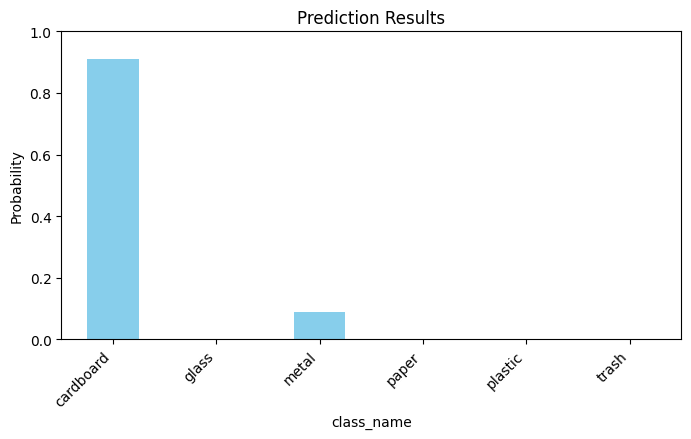

In [134]:
prob = np.reshape(features, -1)

# Convert to a Pandas DataFrame
df = pd.DataFrame({'class_name': class_names,'probability': prob}, columns=['class_name', 'probability'])
#print(df)

# Plot the bar chart
df.plot.bar(x='class_name', y='probability', color='skyblue', legend=False, figsize=(8, 4), title="Prediction Results")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Probability")
plt.ylim(0, 1)  # Optional: Set y-axis limits
plt.show()

In [135]:
# find the index of the class with maximum score
pred = np.argmax(features, axis=-1)
# print the label of the class with maximum score
print("The image was classified as:",class_names[pred[0]])

The image was classified as: cardboard
